In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Dropout, BatchNormalization, Bidirectional, CuDNNLSTM
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from tensorflow.keras.optimizers import Adam
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
import re
from google.colab import drive
import tensorflow as tf
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [ ]:
merged_df = pd.read_csv('/data2022_features.csv')

In [ ]:
X = merged_df.drop(merged_df.columns[[0,1,2,3]], axis=1) 
Y = (merged_df['reliability']).values
Y = Y.astype(int)
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)

print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

In [ ]:
max_fatures = 20000 #unique words, set threshold on if it appears >3 times in dataset
tokenizer = Tokenizer(num_words=max_fatures, split=' ', oov_token='<unw>')
tokenizer.fit_on_texts(merged_df['body_text_processed'].values)
X_train_text = tokenizer.texts_to_sequences(X_train['body_text_processed'].values)
X_train_text = pad_sequences(X_train_text, padding = 'post', maxlen = 3500) #max words in article, set to largest word count 
X_train_features = X_train.drop(X_train.columns[0], axis=1) 
X_test_text = tokenizer.texts_to_sequences(X_test['body_text_processed'].values)
X_test_text = pad_sequences(X_test_text, padding = 'post', maxlen = 3500) #max words in article, set to largest word count 
X_test_features = X_test.drop(X_test.columns[0], axis=1) 

In [ ]:
merged_df['reliability']

In [ ]:
X_train_text.shape

In [ ]:
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

In [ ]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('/content/gdrive/Shareddrives/National Undergraduate Big Data Challenge 2021/glove.6B.100d.txt', encoding="utf8")

In [ ]:
for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions

glove_file.close()

In [ ]:
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [ ]:
#GRU
from keras.layers import Dense, Embedding, LSTM, Bidirectional, Input, concatenate, GRU
model4 = Sequential()
model4.add(Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=X_train_text.shape[1], trainable=True))
model4.add(SpatialDropout1D(0.5))
model4.add(Bidirectional(GRU(50)))
#model4.add(layer = Dropout(rate = 0.5))
model4.add(Dense(1,activation='sigmoid'))
optimizer = Adam(learning_rate=0.001)
model4.compile(loss = 'binary_crossentropy', optimizer=optimizer,metrics = ['accuracy'])
print(model4.summary())
#, dropout=0.4, recurrent_dropout=0.4)


In [ ]:
# Model Fitting
H = model4.fit(x=[X_train_text], y=Y_train, epochs = 10, batch_size=64, validation_split=0.2,verbose=1)

In [ ]:
X_full = tokenizer.texts_to_sequences(X['body_text_processed'].values)
X_full = pad_sequences(X_full, padding = 'post', maxlen = 3500) #max words in article, set to largest word count 
X_full_features = X.drop(X.columns[0], axis=1) 

In [ ]:
preds = model4.predict([X_full])

In [ ]:
preds

In [ ]:
X_full_features['pred'] = preds

In [ ]:
X_full_features

In [ ]:
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from matplotlib import pyplot

X_train, X_test, y_train, y_test = train_test_split(X_full_features, Y, test_size=0.2, random_state=42)
eval_set = [(X_train, y_train), (X_test, y_test)]

model = XGBClassifier(silent=False, 
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.6,
                      subsample = 0.6,
                      objective='binary:logistic', 
                      n_estimators=300, 
                      reg_alpha = 0.9,
                      reg_lambda = 10,
                      max_depth=3, 
                      gamma=10, 
                      random_state = 42)

In [ ]:
model.fit(X_train, y_train, eval_metric=["error", "logloss",'auc'], eval_set=eval_set, verbose=True)

[0]	validation_0-error:0.2721	validation_0-logloss:0.690948	validation_0-auc:0.67887	validation_1-error:0.285714	validation_1-logloss:0.691013	validation_1-auc:0.646321
[1]	validation_0-error:0.114107	validation_0-logloss:0.684635	validation_0-auc:0.94469	validation_1-error:0.130326	validation_1-logloss:0.684975	validation_1-auc:0.929742
[2]	validation_0-error:0.09906	validation_0-logloss:0.678396	validation_0-auc:0.948924	validation_1-error:0.110276	validation_1-logloss:0.679066	validation_1-auc:0.933056
[3]	validation_0-error:0.097806	validation_0-logloss:0.672167	validation_0-auc:0.94955	validation_1-error:0.105263	validation_1-logloss:0.673151	validation_1-auc:0.93365
[4]	validation_0-error:0.097806	validation_0-logloss:0.666113	validation_0-auc:0.9496	validation_1-error:0.105263	validation_1-logloss:0.66742	validation_1-auc:0.935083
[5]	validation_0-error:0.093417	validation_0-logloss:0.660259	validation_0-auc:0.956052	validation_1-error:0.112782	validation_1-logloss:0.661834	vali

XGBClassifier(colsample_bytree=0.6, gamma=10, learning_rate=0.01,
              n_estimators=300, random_state=42, reg_alpha=0.9, reg_lambda=10,
              silent=False, subsample=0.6)

Accuracy: 89.72%


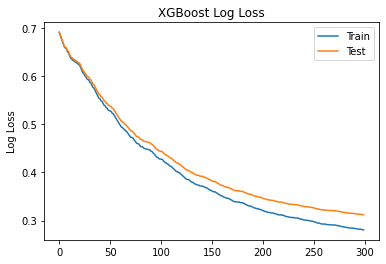

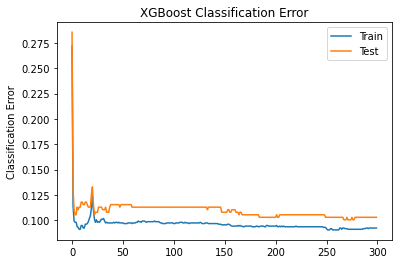

In [ ]:
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from matplotlib import pyplot

# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Log Loss')
pyplot.show()
# plot classification error
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
pyplot.ylabel('Classification Error')
pyplot.title('XGBoost Classification Error')
pyplot.show()

In [ ]:
y_pred

array([1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1,
       0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1,
       0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0,

In [ ]:
y_test

array([1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1,
       0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0,
       0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.84      0.84       127
           1       0.93      0.92      0.92       272

    accuracy                           0.90       399
   macro avg       0.88      0.88      0.88       399
weighted avg       0.90      0.90      0.90       399



In [ ]:
from sklearn.metrics import precision_recall_fscore_support as score

precision, recall, fscore, support = score(y_test, y_pred, average = 'binary')

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: 0.9261992619926199
recall: 0.9227941176470589
fscore: 0.9244935543278084
support: None


In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
y_pred_keras = model4.predict([X_test_text])
fpr_keras, tpr_keras, thresholds_keras = roc_curve(Y_test, y_pred_keras)
auc_keras = auc(fpr_keras, tpr_keras)

In [ ]:
from sklearn.metrics import classification_report

y_pred_bool = y_pred_keras.round()

print(classification_report(Y_test, y_pred_bool))

              precision    recall  f1-score   support

           0       0.79      0.71      0.75        62
           1       0.88      0.91      0.89       138

    accuracy                           0.85       200
   macro avg       0.83      0.81      0.82       200
weighted avg       0.85      0.85      0.85       200



In [ ]:
from sklearn.metrics import precision_recall_fscore_support as score

precision, recall, fscore, support = score(Y_test, y_pred_bool, average = 'binary')

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: 0.875
recall: 0.9130434782608695
fscore: 0.8936170212765957
support: None


In [ ]:
chi = merged_df.drop(merged_df.columns[[0,2,3]], axis=1) 
rel = chi.loc[chi['reliability'].astype(int) == 1]
rel = rel.drop(rel.columns[0], axis=1) 
unrel = chi.loc[chi['reliability'].astype(int) == 0]
unrel = unrel.drop(unrel.columns[0], axis=1) 


KeyError: ignored

In [ ]:
from scipy import stats
t_results = []
for i in rel.columns:
  ttest = stats.ttest_ind(rel[i], unrel[i])
  t_results.append(ttest)
t_df = pd.DataFrame(t_results)
t_df.index = rel.columns

In [ ]:
rel

In [ ]:
t_df['rel_mean'] = float()
t_df['unrel_mean'] = float()
t_df['rel_stdev'] = float()
t_df['unrel_stdev'] = float()
t_df['rel_article_count'] = float()
t_df['unrel_article_count'] = float()

for col in rel.columns:
    t_df.at[col, 'rel_mean'] = rel[col].mean()
    t_df.at[col, 'unrel_mean'] = unrel[col].mean()
    t_df.at[col, 'rel_stdev'] = rel[col].std()
    t_df.at[col, 'unrel_stdev'] = unrel[col].std()
    t_df.at[col, 'rel_article_count'] = len(rel[col])
    t_df.at[col, 'unrel_article_count'] = len(unrel[col])
    

In [ ]:
t_df

In [ ]:
t_df.to_csv('/content/gdrive/Shareddrives/National Undergraduate Big Data Challenge 2021/NEWSTUFF_March2022/statistics.csv')

In [ ]:
rel.pos.mean()